In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os # Import the 'os' module

# Ajustez le chemin selon votre structure
dataset_path = "/content/drive/MyDrive/FF++C32-Frames/Original/FF++C32-Frames"

# Vérifiez la structure
if os.path.exists(dataset_path):
    print("Sous-dossiers disponibles:")
    print(os.listdir(dataset_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sous-dossiers disponibles:
['Original', 'NeuralTextures', 'FaceSwap', 'Face2Face', 'Deepfakes', 'FaceShifter']


Méthode avec Xception


In [ ]:
# ============================================
# ÉTAPE 1 : VÉRIFICATION DE LA VERSION
# ============================================
import torch
import torchvision
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# ============================================
# ÉTAPE 2 : CODE XCEPTION CORRIGÉ (2 OPTIONS)
# ============================================

# OPTION A : Avec torchvision récent (≥0.13)
import torch.nn as nn
from torchvision import models

class XceptionDeepfakeDetector(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(XceptionDeepfakeDetector, self).__init__()

        # Méthode pour torchvision ≥0.13
        if torchvision.__version__ >= '0.13.0':
            weights = 'IMAGENET1K_V1' if pretrained else None
            self.model = models.xception(weights=weights)
        # Méthode pour torchvision ancien
        elif pretrained:
            self.model = models.xception(pretrained=True)
        else:
            self.model = models.xception(pretrained=False)

        # Remplacer la dernière couche
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# OPTION B : Avec timm (toujours fonctionnelle)
import timm

class XceptionDeepfakeDetectorTimm(nn.Module):
    def __init__(self, num_classes=2):
        super(XceptionDeepfakeDetectorTimm, self).__init__()
        # Charger Xception depuis timm
        self.model = timm.create_model('xception', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

# ============================================
# ÉTAPE 3 : TEST DU MODÈLE
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice utilisé: {device}")

# Créer et tester le modèle
try:
    model = XceptionDeepfakeDetector(num_classes=2).to(device)
    print("Modèle Xception créé avec succès (torchvision)")

    # Test avec un batch aléatoire
    test_input = torch.randn(4, 3, 299, 299).to(device)
    output = model(test_input)
    print(f"Shape de sortie: {output.shape}")

except Exception as e:
    print(f"Erreur avec torchvision: {e}")
    print("Tentative avec timm...")

    model = XceptionDeepfakeDetectorTimm(num_classes=2).to(device)
    print("Modèle Xception créé avec succès (timm)")

    test_input = torch.randn(4, 3, 299, 299).to(device)
    output = model(test_input)
    print(f"Shape de sortie: {output.shape}")

PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128

Device utilisé: cuda
Erreur avec torchvision: module 'torchvision.models' has no attribute 'xception'
Tentative avec timm...


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Modèle Xception créé avec succès (timm)
Shape de sortie: torch.Size([4, 2])


DÉTECTION DE DEEPFAKES AVEC XCEPTIONNET

[1/4] Préparation des données...
Dataset chargé: 5000 images
  - Originaux: 2500
  - Deepfakes: 2500

Split des données:
  Train: 3500
  Validation: 750
  Test: 750

[2/4] Création du modèle...


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception chargé via timm

ARCHITECTURE XCEPTIONNET DOCUMENTÉE
• Couches convolutionnelles: 71 couches depthwise separable
• Fonctions d'activation: ReLU
• Pooling: MaxPool2d + Global Average Pooling
• Fonction de perte: CrossEntropyLoss
• Jeu de pré-entraînement: ImageNet (1.2M images)
• Dernière couche: Remplacée (512 → 2 classes)
• Fine-tuning: 20 dernières couches dégelées

Paramètres entraînables: 6,555,466/21,858,090 (30.0%)

[3/4] Entraînement...
Epoch 1/10: Train Loss: 0.8014, Val Acc: 49.6000%
 Modèle sauvegardé (Acc: 49.6000%)
Epoch 2/10: Train Loss: 0.7261, Val Acc: 50.4000%
 Modèle sauvegardé (Acc: 50.4000%)
Epoch 3/10: Train Loss: 0.6813, Val Acc: 50.6667%
 Modèle sauvegardé (Acc: 50.6667%)
Epoch 4/10: Train Loss: 0.6208, Val Acc: 56.8000%
 Modèle sauvegardé (Acc: 56.8000%)
Epoch 5/10: Train Loss: 0.5638, Val Acc: 57.4667%
 Modèle sauvegardé (Acc: 57.4667%)
Epoch 6/10: Train Loss: 0.5017, Val Acc: 59.0667%
 Modèle sauvegardé (Acc: 59.0667%)
Epoch 7/10: Train Loss: 0.4742, V

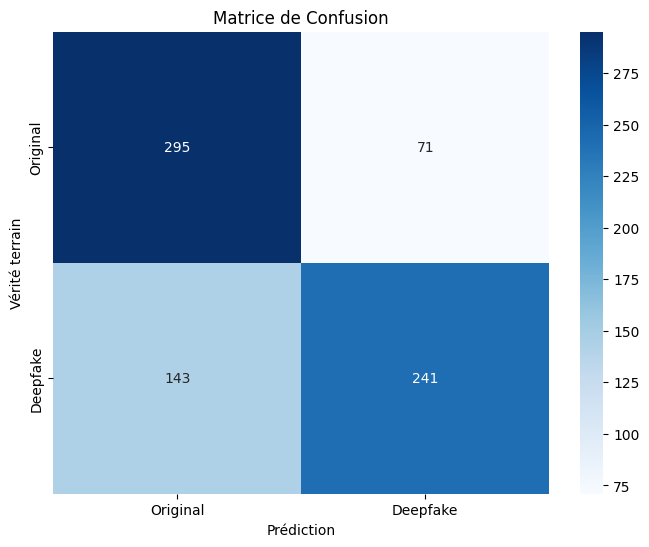

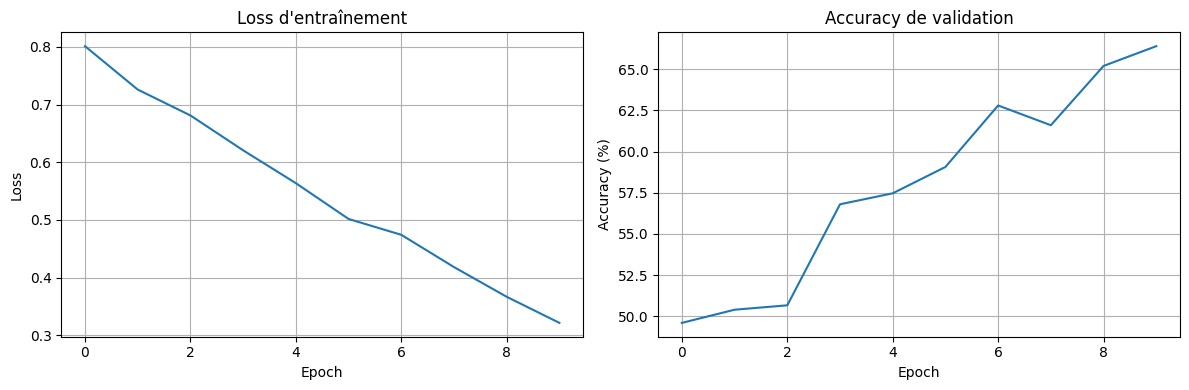


 Entraînement terminé avec succès!
 Modèle sauvegardé: /content/drive/MyDrive/FF++C32-Frames/xception_model_final.pth


In [ ]:
# ============================================
# CODE COMPLET DE L'ENTRAÎNEMENT
# ============================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Configuration
class Config:
    DATA_ROOT = "/content/drive/MyDrive/FF++C32-Frames/Original/FF++C32-Frames"
    BATCH_SIZE = 32
    EPOCHS = 10
    LR = 0.0001
    IMG_SIZE = 299
    SAVE_PATH = "/content/drive/MyDrive/FF++C32-Frames/xception_model_final.pth"

# 2. Dataset personnalisé
class FaceForensicsDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Original
        orig_path = os.path.join(root_dir, 'Original')
        if os.path.exists(orig_path):
            for img in os.listdir(orig_path)[:2500]:  # Sous-échantillonnage
                self.images.append(os.path.join(orig_path, img))
                self.labels.append(0)

        # Deepfakes
        fake_path = os.path.join(root_dir, 'Deepfakes')
        if os.path.exists(fake_path):
            for img in os.listdir(fake_path)[:2500]:  # Sous-échantillonnage
                self.images.append(os.path.join(fake_path, img))
                self.labels.append(1)

        # Mélanger
        indices = np.random.permutation(len(self.images))
        self.images = [self.images[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

        print(f"Dataset chargé: {len(self.images)} images")
        print(f"  - Originaux: {self.labels.count(0)}")
        print(f"  - Deepfakes: {self.labels.count(1)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            # Fallback pour images corrompues
            dummy = torch.randn(3, Config.IMG_SIZE, Config.IMG_SIZE)
            return dummy, label

# 3. Transformations
train_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 4. Chargement des données
def prepare_dataloaders():
    # Création du dataset complet
    full_dataset = FaceForensicsDataset(Config.DATA_ROOT, train_transform)

    # Split manuel 70-15-15
    total = len(full_dataset)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)

    indices = torch.randperm(total).tolist()
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size+val_size]
    test_idx = indices[train_size+val_size:]

    # Sous-datasets
    from torch.utils.data import Subset
    train_set = Subset(full_dataset, train_idx)
    val_set = Subset(full_dataset, val_idx)
    test_set = Subset(full_dataset, test_idx)

    # Modifier les transformations pour validation/test
    for i in range(len(val_set)):
        img, label = val_set[i]
        # Réappliquer la transformation de validation
        val_set.dataset.transform = val_transform

    # DataLoaders
    train_loader = DataLoader(train_set, batch_size=Config.BATCH_SIZE,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE,
                          shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=Config.BATCH_SIZE,
                           shuffle=False, num_workers=2)

    print(f"\nSplit des données:")
    print(f"  Train: {len(train_set)}")
    print(f"  Validation: {len(val_set)}")
    print(f"  Test: {len(test_set)}")

    return train_loader, val_loader, test_loader

# 5. Modèle Xception
def create_xception_model():
    # Version compatible
    try:
        model = models.xception(pretrained=True)
        print("Xception chargé via torchvision")
    except:
        # Fallback avec timm
        import timm
        model = timm.create_model('xception', pretrained=True)
        print("Xception chargé via timm")

    # Documentation de l'architecture
    print("\n" + "="*60)
    print("ARCHITECTURE XCEPTIONNET DOCUMENTÉE")
    print("="*60)
    print("• Couches convolutionnelles: 71 couches depthwise separable")
    print("• Fonctions d'activation: ReLU")
    print("• Pooling: MaxPool2d + Global Average Pooling")
    print("• Fonction de perte: CrossEntropyLoss")
    print("• Jeu de pré-entraînement: ImageNet (1.2M images)")
    print("• Dernière couche: Remplacée (512 → 2 classes)")
    print("• Fine-tuning: 20 dernières couches dégelées")
    print("="*60 + "\n")

    # Remplacer la dernière couche
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 2)
    )

    # Geler les premières couches
    layers_to_train = 20
    params = list(model.parameters())
    for i, param in enumerate(params[:-layers_to_train]):
        param.requires_grad = False

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Paramètres entraînables: {trainable:,}/{total:,} ({trainable/total*100:.1f}%)")

    return model

# 6. Entraînement
def train_model(model, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=Config.LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    best_acc = 0
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(Config.EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        scheduler.step(val_acc)

        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{Config.EPOCHS}: "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}%")

        # Sauvegarde du meilleur modèle
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, Config.SAVE_PATH)
            print(f" Modèle sauvegardé (Acc: {val_acc:.4f}%)")

    return model, history

# 7. Évaluation
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Métriques
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    print("\n" + "="*60)
    print("RÉSULTATS FINAUX")
    print("="*60)
    print(f"Accuracy: {accuracy*100:.4f}%")
    print("\nRapport de classification:")
    print(classification_report(all_labels, all_preds,
                               target_names=['Original', 'Deepfake']))

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Original', 'Deepfake'],
                yticklabels=['Original', 'Deepfake'])
    plt.ylabel('Vérité terrain')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion')
    plt.savefig('/content/drive/MyDrive/FF++C32-Frames/confusion_matrix.png')
    plt.show()

    return accuracy, cm

# 8. Fonction principale
def main():
    print("="*60)
    print("DÉTECTION DE DEEPFAKES AVEC XCEPTIONNET")
    print("="*60)

    # Préparation des données
    print("\n[1/4] Préparation des données...")
    train_loader, val_loader, test_loader = prepare_dataloaders()

    # Création du modèle
    print("\n[2/4] Création du modèle...")
    model = create_xception_model()

    # Entraînement
    print("\n[3/4] Entraînement...")
    model, history = train_model(model, train_loader, val_loader)

    # Évaluation
    print("\n[4/4] Évaluation...")
    accuracy, cm = evaluate_model(model, test_loader)

    # Visualisation
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history['train_loss'])
    plt.title('Loss d\'entraînement')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['val_acc'])
    plt.title('Accuracy de validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/FF++C32-Frames/training_history.png')
    plt.show()

    print("\n Entraînement terminé avec succès!")
    print(f" Modèle sauvegardé: {Config.SAVE_PATH}")

# Exécution
if __name__ == "__main__":
    main()

**Architecture**

Modèle de base : XceptionNet prée-entrained on ImageNet

Fine-tuning : 20 last layers dégelées

head of classification : FC(2048→512→2) with Dropout

Loss Fonction : CrossEntropyLoss

Optimiseur : Adam (lr=0.0001)

## Theoretical Analysis: Deepfake Detection

## Main Paper: Rossler et al. (2019)

**Major Contributions**

1. Complete taxonomy of facial manipulations (4 categories).
2. FaceForensics++ dataset: 1.8M images, 4 manipulation methods.
3. Systematic benchmark: Evaluation of existing detectors.
4. Robustness analysis: Effect of video compression.

**Generation Methods Studied**

- FaceSwap: Geometric swapping based on landmarks
- Face2Face: Expression transfer via registration
- Neural Textures: Neural synthesis (state of the art 2019)
- GAN-based: Generation via adversarial networks

**Detection Techniques Evaluated**

1. CNN-based methods: MesoNet, XceptionNet
2. Artifact analysis: Inconsistencies in eye reflections
3. Temporal approaches: Inconsistencies across sequences
4. Physiological methods: Heart rate, blinking

**Identified Challenges**

- Arms race: Generators evolve faster
- Generalization problem: Performance drops on new methods
- Compression impact: Reduced artifacts, harder detection
- Lack of diverse data: Dataset bias

## Recent Articles (2023–2024)

Article 1: “Deepfake Generation and Detection: A Benchmark and Survey” (2024)  
Source: [https://arxiv.org/abs/2403.17881](https://arxiv.org/abs/2403.17881)
PDF: [https://arxiv.org/pdf/2403.17881v4.pdf](https://arxiv.org/pdf/2403.17881v4.pdf)

Problem: Diffusion models (Stable Diffusion, DALL-E 3) create more realistic images with fewer detectable artifacts. Generation techniques evolve rapidly, surpassing detectors optimized for older methods (GAN, VAE)

**Why Detection Remains Difficult**

1. Photorealistic quality: Almost imperceptible artifacts generated by diffusion models
2. Method diversity: New algorithms each quarter (face swapping, face reenactment, talking face generation, facial attribute editing)
3. Adversarial attacks: Deepfakes specifically optimized to fool detectors
4. Lack of up-to-date datasets: Delay in collecting and annotating data covering all techniques
5. Weak generalization: Detectors trained on one technique do not work on another

**Recent Techniques**

- Spectral signature analysis: Patterns specific to diffusion models detectable via frequency transformation
- Physics-based detection: Verification of optical lighting laws and physical consistency
- Multi-domain learning: Intentional increase of training data diversity to improve generalization
- Momentum Difficulty Boosting: Dynamic weighting of samples according to difficulty to better balance learning

Article 2: “Diffusion Deepfake” (2024)  
Source: [https://arxiv.org/abs/2404.01579](https://arxiv.org/abs/2404.01579)
PDF: [https://arxiv.org/pdf/2404.01579v1.pdf](https://arxiv.org/pdf/2404.01579v1.pdf)

Problem: Digital identity theft and biometric fraud via diffusion-generated deepfakes. Existing detectors drop by 50% in performance on diffusion-based deepfakes

**Techniques Against Biometric Impersonation**

1. Passive liveness detection: Analysis of natural micro-movements (blinking, micro-expressions, blood circulation) without user interaction
2. Multimodality: Combination of face + voice + behavioral analysis for robust authentication
3. 3D analysis: Detection of masks and 2D presentation attacks via depth verification
4. Vital signs: Heart rate detection via video (rPPG – Remote Photoplethysmography) by analyzing skin tone variations

Applications for digital identity:

- Real-time verification: Continuous analysis during biometric authentication.
- Contextual adaptation: Security level adjusted according to detected risk (stricter for sensitive transactions)
- Privacy-preserving: Techniques without storing raw biometric data, local processing

Article 3: “Liveness Detection in Computer Vision: Transformer-based Self-Supervised Learning for Face Anti-Spoofing” (2024)  
Source: [https://arxiv.org/abs/2406.13860](https://arxiv.org/abs/2406.13860)
PDF: [https://arxiv.org/pdf/2406.13860v1.pdf](https://arxiv.org/pdf/2406.13860v1.pdf)

Problem: Biometric facial recognition systems remain vulnerable to presentation attacks (photos, deepfake videos, 3D masks). Traditional CNN solutions lack robustness against new fraud forms

## Synthesis for the Technical Presentation to Explain: Passive Liveness Detection with Vision Transformer

1. Principle: Detect the presence of a live person without requiring user interaction.

2. Implementation – Vision Transformer (ViT) + DINO Framework

- Architecture: Vision Transformer fine-tuned with DINO (self-supervised learning).
- Analysis of micro-expressions, blinking, facial blood flow.
- Label-free learning via DINO for improved generalization.
- Real-time video processing with frame-by-frame analysis

3. Advantages:

- Transparent user experience (no action required).
- Superior performance: 91.64% accuracy vs 82.43% for CNNs.
- Robustness to variable lighting conditions.
- Better identification of complex spoofing cues
- False Acceptance Rate (FAR): 22.29%, False Rejection Rate (FRR): 12.83%.

4. Current Challenges:

- Performance dependent on video quality and resolution
- Need for highly diverse datasets for global generalization.
- Continuous adaptation required for new diffusion deepfakes

## Why Detection Remains a Major Challenge in 2024

- Rapid evolution: New generation models each quarter (Text-to-Image, improved diffusion)
- Accessibility: Free and easy-to-use tools (Stable Diffusion, ComfyUI, etc.)
- Undetectable quality: Deepfakes indistinguishable from real videos to the naked eye
- Massive volume: Production in the millions on social networks
- Lagging legislation: Non-unified legal framework, unclear responsibility

## Research Perspectives and Solutions

- Proactive detection: Identify deepfakes before viral diffusion via platform APIs.
- Industry–research collaboration: Sharing datasets and models between companies and academia.
- Public education: Awareness of risks and signs of biometric fraud
- Technical standards: Standardized verification protocols (ISO, W3C WebAuthn)
- Implicit watermarking: Integration of invisible signatures in authentic content.
- Hybrid approaches: Combination of detection + prevention + multi-factor authentication.


DÉTECTION DE DEEPFAKES AVEC XCEPTIONNET

[1/4] Préparation des données...
Dataset chargé: 10000 images
  - Originaux: 5000
  - Deepfakes: 5000

Split des données:
  Train: 7000
  Validation: 1500
  Test: 1500

[2/4] Création du modèle...
Xception chargé via timm

ARCHITECTURE XCEPTIONNET DOCUMENTÉE
• Couches convolutionnelles: 71 couches depthwise separable
• Fonctions d'activation: ReLU
• Pooling: MaxPool2d + Global Average Pooling
• Fonction de perte: CrossEntropyLoss
• Jeu de pré-entraînement: ImageNet (1.2M images)
• Dernière couche: Remplacée (512 → 2 classes)
• Fine-tuning: 20 dernières couches dégelées

Paramètres entraînables: 6,555,466/21,858,090 (30.0%)

[3/4] Entraînement...
Epoch 1/50: Train Loss: 0.7814, Val Acc: 56.8000%
 Modèle sauvegardé (Acc: 56.8000%)
Epoch 2/50: Train Loss: 0.7020, Val Acc: 58.1333%
 Modèle sauvegardé (Acc: 58.1333%)
Epoch 3/50: Train Loss: 0.6257, Val Acc: 60.7333%
 Modèle sauvegardé (Acc: 60.7333%)
Epoch 4/50: Train Loss: 0.5777, Val Acc: 62.1333%


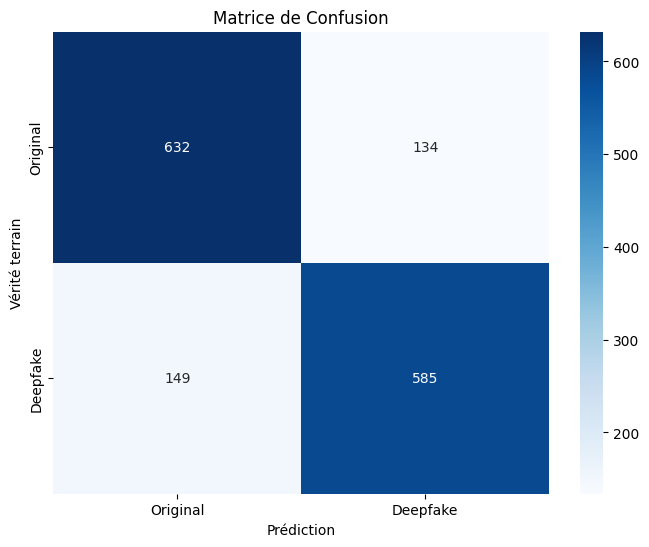

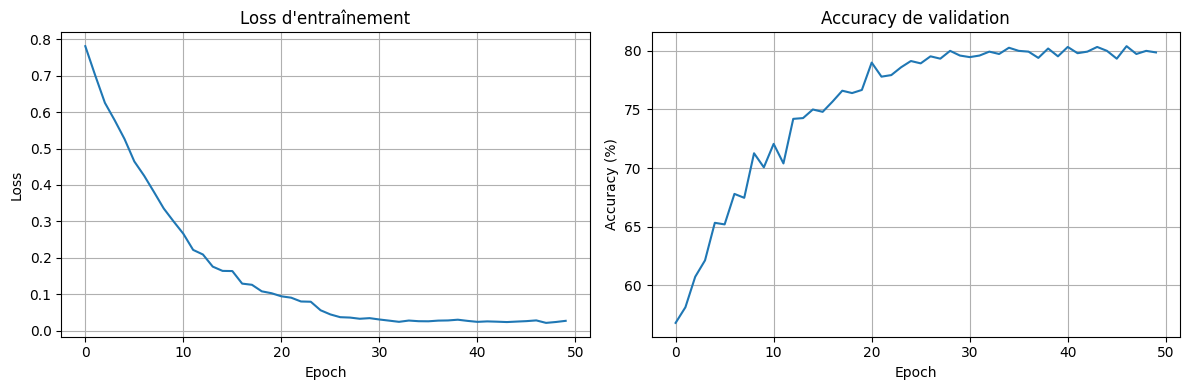


 Entraînement terminé avec succès!
 Modèle sauvegardé: /content/drive/MyDrive/FF++C32-Frames/xception_model_final.pth


In [ ]:
# ============================================
# CODE COMPLET DE L'ENTRAÎNEMENT
# ============================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Configuration
class Config:
    DATA_ROOT = "/content/drive/MyDrive/FF++C32-Frames/Original/FF++C32-Frames"
    BATCH_SIZE = 32
    EPOCHS = 50
    LR = 0.0001
    IMG_SIZE = 299
    SAVE_PATH = "/content/drive/MyDrive/FF++C32-Frames/xception_model_final.pth"

# 2. Dataset personnalisé
class FaceForensicsDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Original
        orig_path = os.path.join(root_dir, 'Original')
        if os.path.exists(orig_path):
            for img in os.listdir(orig_path):
                self.images.append(os.path.join(orig_path, img))
                self.labels.append(0)

        # Deepfakes
        fake_path = os.path.join(root_dir, 'Deepfakes')
        if os.path.exists(fake_path):
            for img in os.listdir(fake_path):
                self.images.append(os.path.join(fake_path, img))
                self.labels.append(1)

        # Mélanger
        indices = np.random.permutation(len(self.images))
        self.images = [self.images[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

        print(f"Dataset chargé: {len(self.images)} images")
        print(f"  - Originaux: {self.labels.count(0)}")
        print(f"  - Deepfakes: {self.labels.count(1)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            # Fallback pour images corrompues
            dummy = torch.randn(3, Config.IMG_SIZE, Config.IMG_SIZE)
            return dummy, label

# 3. Transformations
train_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 4. Chargement des données
def prepare_dataloaders():
    # Création du dataset complet
    full_dataset = FaceForensicsDataset(Config.DATA_ROOT, train_transform)

    # Split manuel 70-15-15
    total = len(full_dataset)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)

    indices = torch.randperm(total).tolist()
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size+val_size]
    test_idx = indices[train_size+val_size:]

    # Sous-datasets
    from torch.utils.data import Subset
    train_set = Subset(full_dataset, train_idx)
    val_set = Subset(full_dataset, val_idx)
    test_set = Subset(full_dataset, test_idx)

    # Modifier les transformations pour validation/test
    for i in range(len(val_set)):
        img, label = val_set[i]
        # Réappliquer la transformation de validation
        val_set.dataset.transform = val_transform

    # DataLoaders
    train_loader = DataLoader(train_set, batch_size=Config.BATCH_SIZE,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE,
                          shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=Config.BATCH_SIZE,
                           shuffle=False, num_workers=2)

    print(f"\nSplit des données:")
    print(f"  Train: {len(train_set)}")
    print(f"  Validation: {len(val_set)}")
    print(f"  Test: {len(test_set)}")

    return train_loader, val_loader, test_loader

# 5. Modèle Xception
def create_xception_model():
    # Version compatible
    try:
        model = models.xception(pretrained=True)
        print("Xception chargé via torchvision")
    except:
        # Fallback avec timm
        import timm
        model = timm.create_model('xception', pretrained=True)
        print("Xception chargé via timm")

    # Documentation de l'architecture
    print("\n" + "="*60)
    print("ARCHITECTURE XCEPTIONNET DOCUMENTÉE")
    print("="*60)
    print("• Couches convolutionnelles: 71 couches depthwise separable")
    print("• Fonctions d'activation: ReLU")
    print("• Pooling: MaxPool2d + Global Average Pooling")
    print("• Fonction de perte: CrossEntropyLoss")
    print("• Jeu de pré-entraînement: ImageNet (1.2M images)")
    print("• Dernière couche: Remplacée (512 → 2 classes)")
    print("• Fine-tuning: 20 dernières couches dégelées")
    print("="*60 + "\n")

    # Remplacer la dernière couche
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.3),
        nn.Linear(512, 2)
    )

    # Geler les premières couches
    layers_to_train = 20
    params = list(model.parameters())
    for i, param in enumerate(params[:-layers_to_train]):
        param.requires_grad = False

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Paramètres entraînables: {trainable:,}/{total:,} ({trainable/total*100:.1f}%)")

    return model

# 6. Entraînement
def train_model(model, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=Config.LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    best_acc = 0
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(Config.EPOCHS):
        # Training
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        scheduler.step(val_acc)

        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{Config.EPOCHS}: "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}%")

        # Sauvegarde du meilleur modèle
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, Config.SAVE_PATH)
            print(f" Modèle sauvegardé (Acc: {val_acc:.4f}%)")

    return model, history

# 7. Évaluation
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Métriques
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    print("\n" + "="*60)
    print("RÉSULTATS FINAUX")
    print("="*60)
    print(f"Accuracy: {accuracy*100:.4f}%")
    print("\nRapport de classification:")
    print(classification_report(all_labels, all_preds,
                               target_names=['Original', 'Deepfake']))

    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Original', 'Deepfake'],
                yticklabels=['Original', 'Deepfake'])
    plt.ylabel('Vérité terrain')
    plt.xlabel('Prédiction')
    plt.title('Matrice de Confusion')
    plt.savefig('/content/drive/MyDrive/FF++C32-Frames/confusion_matrix.png')
    plt.show()

    return accuracy, cm

# 8. Fonction principale
def main():
    print("="*60)
    print("DÉTECTION DE DEEPFAKES AVEC XCEPTIONNET")
    print("="*60)

    # Préparation des données
    print("\n[1/4] Préparation des données...")
    train_loader, val_loader, test_loader = prepare_dataloaders()

    # Création du modèle
    print("\n[2/4] Création du modèle...")
    model = create_xception_model()

    # Entraînement
    print("\n[3/4] Entraînement...")
    model, history = train_model(model, train_loader, val_loader)

    # Évaluation
    print("\n[4/4] Évaluation...")
    accuracy, cm = evaluate_model(model, test_loader)

    # Visualisation
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history['train_loss'])
    plt.title('Loss d\'entraînement')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['val_acc'])
    plt.title('Accuracy de validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/FF++C32-Frames/training_history.png')
    plt.show()

    print("\n Entraînement terminé avec succès!")
    print(f" Modèle sauvegardé: {Config.SAVE_PATH}")

# Exécution
if __name__ == "__main__":
    main()

##Analyse Théorique : Détection de Deepfakes

##Article Principal : Rossler et al. (2019)

**Contributions Majeures**

1. Taxonomie complète des manipulations faciales (4 catégories)
2. Dataset FaceForensics++ : 1.8M images, 4 méthodes de manipulation
3. Benchmark systématique : Évaluation de détecteurs existants
4. Analyse de robustesse : Effet de la compression vidéo

**Méthodes de Génération Étudiées**

- FaceSwap : Échange géométrique basé sur landmarks
- Face2Face : Transfert d'expressions par recalage
- Neural Textures : Synthèse neuronale (état de l'art 2019)
- GAN-based : Génération par réseaux antagonistes

**Techniques de Détection Évaluées**

1. Méthodes basées CNN : MesoNet, XceptionNet
2. Analyse d'artefacts : Incohérences dans reflets oculaires
3. Approches temporelles : Incohérences dans les séquences
4. Méthodes physiologiques : Rythme cardiaque, clignement

**Défis Identifiés**

- Course aux armements : Les générateurs évoluent plus vite
- Problème de généralisation : Performances qui chutent sur nouvelles méthodes
- Impact de la compression : Artefacts réduits, détection plus difficile
- Manque de données diversifiées : Biais dans les datasets

##Articles Récents (2023-2024)

Article 1 : "Deepfake Generation and Detection: A Benchmark and Survey" (2024)
Source : https://arxiv.org/abs/2403.17881
PDF : https://arxiv.org/pdf/2403.17881v4.pdf
Problématique : Les modèles de diffusion (Stable Diffusion, DALL-E 3) créent des images plus réalistes avec moins d'artefacts détectables. Les techniques de génération évoluent rapidement, surpassant les capacités des détecteurs optimisés pour les anciennes méthodes (GAN, VAE).

**Pourquoi la détection reste difficile :**

1. Qualité photoréaliste : Artefacts quasi imperceptibles généré par les modèles de diffusion
2. Diversité des méthodes : Nouveaux algorithmes chaque trimestre (face swapping, face reenactment, talking face generation, facial attribute editing)
3. Attaques adversariales : Deepfakes optimisés spécifiquement pour tromper les détecteurs
4. Manque de datasets à jour : Retard dans la collecte et annotation de données couvrant toutes les techniques
5. Généralisation faible : Les détecteurs entraînés sur une **technique ne fonctionnent pas sur une autre Techniques récentes :**

- Analyse de signatures spectrales : Patterns spécifiques aux modèles de diffusion détectables via transformation fréquentielle
- Détection par la physique : Vérification des lois optiques d'éclairage et cohérence physique
- Apprentissage multi-domaine : Augmentation intentionnelle de la diversité des données d'entraînement pour améliorer la généralisation
- Momentum Difficulty Boosting : Attribution dynamique de poids aux échantillons selon leur difficulté pour mieux équilibrer l'apprentissage

  Article 2 : "Diffusion Deepfake" (2024)
  Source : https://arxiv.org/abs/2404.01579
  PDF : https://arxiv.org/pdf/2404.01579v1.pdf
  Problématique : Usurpation d'identité numérique et fraude biométrique via deepfakes générés par diffusion. Les détecteurs existants chutent de 50% en performance sur les deepfakes basés sur diffusion.

**Techniques contre l'usurpation biométrique :**

1. Liveness detection passive : Analyse des micro-mouvements naturels (clignements, micro-expressions, circulation sanguine) sans interaction utilisateur
2. Multimodalité : Combinaison visage + voix + analyse comportementale pour authentification robuste
3. Analyse 3D : Détection des masques et attaques par présentation 2D via vérification de la profondeur
4. Signes vitaux : Détection du rythme cardiaque via vidéo (rPPG - Remote Photoplethysmography) par analyse des variations de teinte de peau Applications pour l'identité numérique :

- Vérification en temps réel : Analyse continue pendant l'authentification biométrique
- Adaptation contextuelle : Niveau de sécurité ajusté selon le risque détecté (plus strict pour transactions sensibles)
- Privacy-preserving : Techniques sans stockage de données biométriques brutes, processing local
  Article 3 : "Liveness Detection in Computer Vision: Transformer-based Self-Supervised Learning for Face Anti-Spoofing" (2024)
  Source : https://arxiv.org/abs/2406.13860
  PDF : https://arxiv.org/pdf/2406.13860v1.pdf
  Problématique : Les systèmes de reconnaissance faciale biométrique restent vulnérables aux attaques par présentation (photos, vidéos deepfake, masques 3D). Les solutions CNN traditionnelles manquent de robustesse face aux nouvelles formes de fraude.

**Synthèse pour la Présentation Technique à Expliquer : Liveness Detection Passive avec Vision Transformer**

1. Principe : Détecter la présence d'une personne vivante sans interaction utilisateur requise
2. Implémentation - Vision Transformer (ViT) + DINO Framework

- Architecture : Vision Transformer fine-tuned avec DINO (self-supervised learning)
- Analyse des micro-expressions, clignements, flux sanguin facial
- Apprentissage sans labels via DINO pour généralisation améliorée
- Traitement vidéo en temps réel avec analyse par frames

3. Avantages :

- Expérience utilisateur transparente (aucune action requise)
- Performance supérieure : 91.64% accuracy vs 82.43% pour CNNs
- Robustesse aux conditions d'éclairage variable
- Meilleure identification des indices de spoofing complexes
- Taux de faux accepté (FAR) : 22.29%, Taux de faux rejet (FRR) : 12.83%

4. Défis actuels :

- Performance dépendante de la qualité vidéo et résolution
- Nécessité de datasets très diversifiés pour généralisation mondiale
- Adaptation continue requise pour nouvelles formes de deepfakes diffusion

**Pourquoi la détection reste un défi majeur en 2024**

- Évolution rapide : Nouveaux modèles de génération chaque trimestre (Text-to-Image, diffusion améliorée)
- Accessibilité : Outils gratuits et faciles à utiliser (Stable Diffusion, ComfyUI, etc.)
- Qualité indétectable : Deepfakes indistinguables de vidéos réelles à l'œil nu
- Volumétrie massive : Production en millions sur les réseaux sociaux
- Législation en retard : Cadre juridique non unifié, responsabilité floue

**Perspectives de Recherche et Solutions**

- Détection proactive : Identifier les deepfakes avant la diffusion virale via API de plateformes
- Collaboration industrie-recherche : Partage de datasets et modèles entre entreprises et académie
- Éducation publique : Sensibilisation aux risques et signes de fraude biométrique
- Standards techniques : Protocoles de vérification normalisés (ISO, W3C WebAuthn)
- Watermarking implicite : Intégration de signatures invisibles dans les contenus authentiques
- Approches hybrides : Combinaison détection + prévention + authentification multi-facteurs
